# Attention as Nadaraya-Watson Kernel Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use('dark_background')

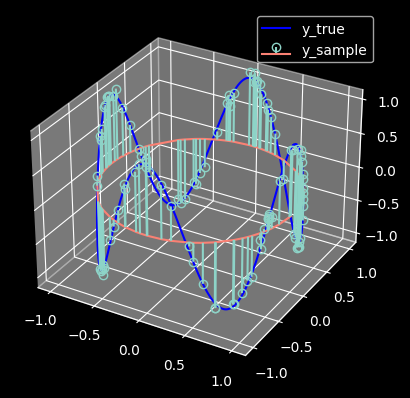

In [2]:
theta_linsp = np.linspace(0, 2*np.pi, 1000)
x_circle = np.stack([np.cos(theta_linsp),np.sin(theta_linsp)], axis=-1)
y_circle = np.cos(4*theta_linsp)

np.random.seed(2023)
idx = np.sort(np.random.randint(0,1000,100))
theta_sample = theta_linsp[idx]

x_sample = np.stack([np.cos(theta_sample),np.sin(theta_sample)], axis=-1)
y_sample = np.cos(4*theta_sample) + np.random.normal(size=100)/20

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot(x_circle[:,0], x_circle[:,1], y_circle, c='b', label='y_true')
markerline, stemlines, baseline = ax.stem(x_sample[:,0], x_sample[:,1], y_sample, label='y_sample')
markerline.set_markerfacecolor('none')
plt.legend()
plt.show()

## Nadaraya-Watson Kernel Regression

Estimator : $$y = \sum_{i=1}^m \alpha(x, x_i)y_i.$$

Use given a kernel $K$ to get weights of labels according to location $x$.

Define $$\alpha(x, x_i) = \frac{K(x-x_i)}{\sum_{j=1}^{m} K(x-x_j)}.$$


* $x$ : query
* $x_i$ : keys ($1 \leq i\leq m$)
* $y_i$ : values ($1 \leq i\leq m$)

### 2D Gaussian
$$f(x,y) = A\exp\left(-\left(\frac{(x-x_0)^2}{2\sigma_X^2} + \frac{(y-y_0)^2}{2\sigma_Y^2}\right)\right)$$
Here the coefficient $A$ is the amplitude, $x_0$, $y_0$ is the center, and $\sigma_X$, $\sigma_Y$ are the x and y spreads of the blob.
[wikipedia](https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function)

Let $\mathbb x=(x,y), \mathbb x_0=(x_0,y_0)\in\mathbb R^2$ and let
$$K(\mathbb x, \mathbb x_0) = \exp\left(-\left(\frac{(x-x_0)^2}{2\sigma_X^2} + \frac{(y-y_0)^2}{2\sigma_Y^2}\right)\right)$$
where $\sigma_X=\sigma_Y=0.01$.

Note that $A$ does not affect the weight $\alpha$.

* $0\leq\|\mathbb x-\mathbb x_0\|\leq 2$
  * If $\|\mathbb x-\mathbb x_0\|=0$, then $K(\mathbb x,\mathbb x_0)=1$.
  * If $\|\mathbb x-\mathbb x_0\|=\sqrt{2}$, then $K(\mathbb x,\mathbb x_0)=\exp(-10000)\simeq 0$.
  * If $\|\mathbb x-\mathbb x_0\|=2$, then $K(\mathbb x,\mathbb x_0)=\exp(-20000)\simeq 0$.


In [3]:
gaussian = lambda x, s=np.array([1,1]), A=1: A*np.exp(-x**2/(2*s**2)).sum(axis=-1)
score = lambda x, m: gaussian(x[:,np.newaxis] - m[np.newaxis,:], np.array([.01, .01]))

a = score(x_circle, x_sample)/score(x_circle, x_sample).sum(axis=1, keepdims=True)
y_pred = (a * y_sample).sum(axis=-1)

mse = ((y_circle - y_pred)**2).mean()

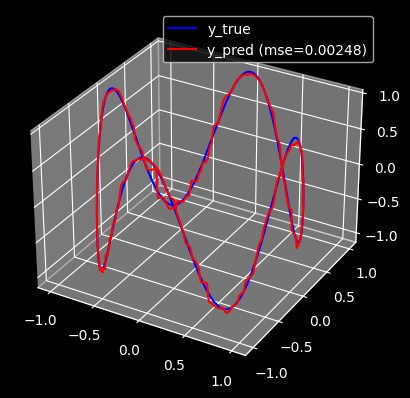

In [4]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot(x_circle[:,0], x_circle[:,1], y_circle, c='b', label='y_true')
ax.plot(x_circle[:,0], x_circle[:,1], y_pred, c='r', label=f'y_pred ({mse=:.5f})')
# markerline, stemlines, baseline = ax.stem(x_sample[:,0], x_sample[:,1], y_sample, label='y_sample')
# markerline.set_markerfacecolor('none')
plt.legend()
plt.show()

### Attention

Let $\mathbb x=(x,y), \mathbb x_0=(x_0,y_0)\in\mathbb R^2$ and let
$$K(\mathbb x, \mathbb x_0) = \exp\left(\frac{\mathbb x\cdot\mathbb x_0}{\sqrt{2}}\right)$$
where $\cdot$ denotes the innerproduct.

Then
$$\alpha(\mathbb x, \mathbb x_i) = \frac{K(\mathbb x,\mathbb x_i)}{\sum_{j=1}^{m} K(\mathbb x, \mathbb x_j)}=\operatorname{softmax}\left(\frac{\mathbb x\cdot\mathbb x_1}{\sqrt{2}}, \frac{\mathbb x\cdot\mathbb x_2}{\sqrt{2}}, \ldots, \frac{\mathbb x\cdot\mathbb x_m}{\sqrt{2}}\right)_i$$
and
$$y = \sum_{i=1}^m\alpha(\mathbb x,\mathbb x_i)y_i = \operatorname{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V.$$
where $Q$ is a $(1000\times 2)$-matrix represents the values `x_circle`, $K$ is a $(100\times 2)$-matrix represents the values `x_sample`, $V$ is a vertical vector represents the values `y_sample`, and $d_k=2$ represents the dimension of $\mathbb x$.

$-1\leq\mathbb x\cdot\mathbb x_0\leq 1$
* If $\mathbb x\cdot\mathbb x_0 = 1$, then $K(\mathbb x,\mathbb x_0)=\exp\left(\frac{1}{\sqrt{2}}\right)\simeq 2.0281$.
* If $\mathbb x\cdot\mathbb x_0 = 0$, then $K(\mathbb x,\mathbb x_0)=\exp\left(0\right) = 1$.
* If $\mathbb x\cdot\mathbb x_0 = -1$, then $K(\mathbb x,\mathbb x_0)=\exp\left(-\frac{1}{\sqrt{2}}\right)\simeq 0.4931$.


In [5]:
def softmax(x, axis=-1):
  m = np.max(x, axis=axis, keepdims=True)
  e = np.exp(x-m)
  s = np.sum(e, axis=axis, keepdims=True)
  return e/s

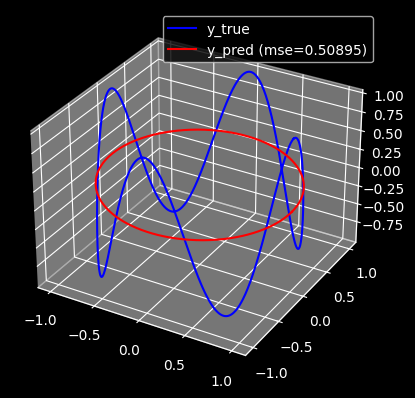

In [6]:
y_pred = np.matmul(softmax(np.matmul(x_circle, x_sample.T)/np.sqrt(2)), y_sample)
mse = ((y_circle - y_pred)**2).mean()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot(x_circle[:,0], x_circle[:,1], y_circle, c='b', label='y_true')
ax.plot(x_circle[:,0], x_circle[:,1], y_pred, c='r', label=f'y_pred ({mse=:.5f})')
# markerline, stemlines, baseline = ax.stem(x_sample[:,0], x_sample[:,1], y_sample, label='y_sample')
# markerline.set_markerfacecolor('none')
plt.legend()
plt.show()

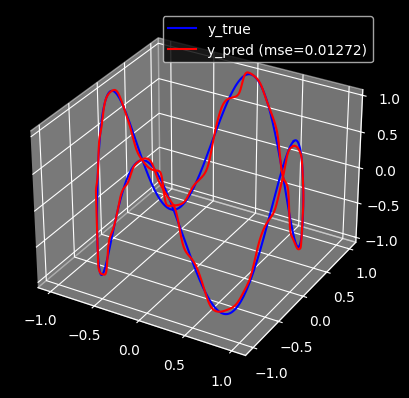

In [7]:
y_pred = np.matmul(softmax(np.matmul(x_circle*20, x_sample.T*20)/np.sqrt(2)), y_sample)
mse = ((y_circle - y_pred)**2).mean()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot(x_circle[:,0], x_circle[:,1], y_circle, c='b', label='y_true')
ax.plot(x_circle[:,0], x_circle[:,1], y_pred, c='r', label=f'y_pred ({mse=:.5f})')
# markerline, stemlines, baseline = ax.stem(x_sample[:,0], x_sample[:,1], y_sample, label='y_sample')
# markerline.set_markerfacecolor('none')
plt.legend()
plt.show()

## MLP

In [8]:
!pip install lion-pytorch


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from lion_pytorch import Lion

In [10]:
class MLP(torch.nn.Module):
  def __init__(self, d_input=2, d_hidden=32, d_output=1):
    super().__init__()
    self.lin1 = torch.nn.Linear(d_input, d_hidden)
    self.lin2 = torch.nn.Linear(d_hidden, d_output)

  def forward(self, x):
    x = torch.relu(self.lin1(x))
    x = self.lin2(x)
    return x

In [11]:
mlp = MLP(2,256,1)
mlp.cuda()

criterion = torch.nn.MSELoss()
optimizer = Lion(mlp.parameters(), lr=0.001)

x_trn = torch.tensor(x_sample, dtype=torch.float32, device='cuda')
y_trn = torch.tensor(y_sample, dtype=torch.float32, device='cuda').unsqueeze(-1)

mlp.train()
for epoch in range(3000):
  y_prd = mlp(x_trn)
  loss = criterion(y_prd, y_trn)
  loss.backward()
  optimizer.step()
  if epoch % 1000 == 0:
    print(epoch, loss.item())
  optimizer.zero_grad()

0 0.6391735076904297
1000 0.005367549601942301
2000 0.005368428770452738


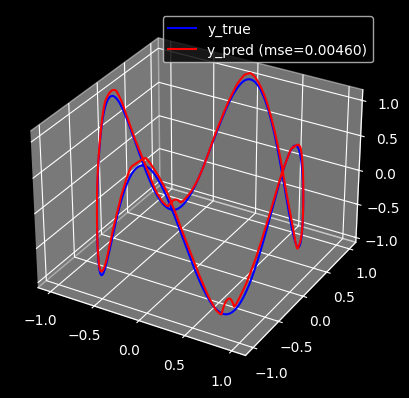

In [ ]:
mlp.eval()
with torch.no_grad():
  y_pred = mlp(torch.tensor(x_circle, dtype=torch.float32, device='cuda'))
y_pred = y_pred.cpu().numpy().flatten()
mse = ((y_circle - y_pred)**2).mean()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot(x_circle[:,0], x_circle[:,1], y_circle, c='b', label='y_true')
ax.plot(x_circle[:,0], x_circle[:,1], y_pred, c='r', label=f'y_pred ({mse=:.5f})')
# markerline, stemlines, baseline = ax.stem(x_sample[:,0], x_sample[:,1], y_sample, label='y_sample')
# markerline.set_markerfacecolor('none')
plt.legend()
plt.show()

## Attention with parameter matrices

In [ ]:
attention = lambda Q,K,V: torch.matmul(torch.softmax(torch.matmul(Q,K.T)/np.sqrt(K.shape[0]), dim=-1), V)

class AttnHead(torch.nn.Module):
  def __init__(self, d_k=2):
    super().__init__()
    self.linQ = torch.nn.Linear(2, d_k)
    self.linK = torch.nn.Linear(2, d_k)
    self.linV = torch.nn.Linear(1, 1)

  def forward(self, q, k, v):
    q = self.linQ(q)
    k = self.linK(k)
    print(k)
    v = self.linV(v)
    print(v)
    return attention(q,k,v)

In [ ]:
attn_head = AttnHead(2)
attn_head.cuda()

criterion = torch.nn.MSELoss()
optimizer = Lion(attn_head.parameters(), lr=0.001)

x_trn = torch.tensor(x_sample, dtype=torch.float32, device='cuda')
y_trn = torch.tensor(y_sample, dtype=torch.float32, device='cuda').unsqueeze(-1)

attn_head.train()
for epoch in range(30000):
  y_prd = attn_head(x_trn, x_trn, y_trn)
  loss = criterion(y_prd, y_trn)
  loss.backward()
  optimizer.step()
  if epoch % 1000 == 0:
    print(epoch, loss.item())
  optimizer.zero_grad()

0 0.644429087638855
1000 0.5019856095314026
2000 0.4914374053478241
3000 0.47812619805336
4000 0.46187612414360046
5000 0.4207664430141449
6000 0.33091461658477783
7000 0.18774135410785675
8000 0.13762231171131134
9000 0.13568426668643951
10000 0.13530786335468292
11000 0.1353074014186859
12000 0.13530747592449188
13000 0.13530752062797546
14000 0.13530698418617249
15000 0.13530753552913666
16000 0.13530755043029785
17000 0.13530761003494263
18000 0.1353067010641098
19000 0.13530725240707397
20000 0.13530731201171875
21000 0.13530713319778442
22000 0.13530747592449188
23000 0.13530725240707397
24000 0.1353072077035904
25000 0.1353081911802292
26000 0.1353076547384262
27000 0.1353072077035904
28000 0.1353084295988083
29000 0.1353072077035904


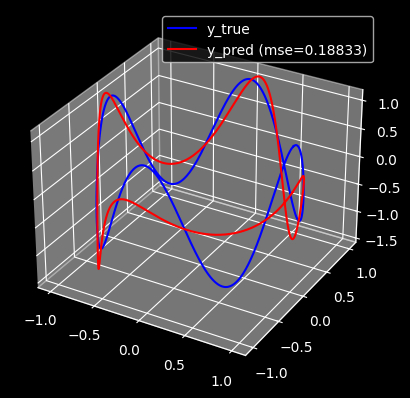

In [15]:
attn_head.eval()
with torch.no_grad():
  y_pred = attn_head(torch.tensor(x_circle, dtype=torch.float32, device='cuda'), x_trn, y_trn)
y_pred = y_pred.cpu().numpy().flatten()
mse = ((y_circle - y_pred)**2).mean()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot(x_circle[:,0], x_circle[:,1], y_circle, c='b', label='y_true')
ax.plot(x_circle[:,0], x_circle[:,1], y_pred, c='r', label=f'y_pred ({mse=:.5f})')
# markerline, stemlines, baseline = ax.stem(x_sample[:,0], x_sample[:,1], y_sample, label='y_sample')
# markerline.set_markerfacecolor('none')
plt.legend()
plt.show()

## Multi-Head Attention
Ensemble of Attentions

In [16]:
class MHAttn(torch.nn.Module):
  def __init__(self, n_heads=4, d_k=3):
    super().__init__()
    self.n_heads = n_heads
    self.d_model = n_heads * d_k
    self.heads = torch.nn.ModuleList([AttnHead(d_k) for _ in range(n_heads)])
    self.linO = torch.nn.Linear(n_heads,1)

  def forward(self, q, k, v):
    outputs = [self.heads[i](q,k,v) for i in range(self.n_heads)]
    return self.linO(torch.concat(outputs, dim=-1))

In [17]:
multi_head = MHAttn(8,2)
multi_head.cuda()

criterion = torch.nn.MSELoss()
optimizer = Lion(multi_head.parameters(), lr=0.001)

x_trn = torch.tensor(x_sample, dtype=torch.float32, device='cuda')
y_trn = torch.tensor(y_sample, dtype=torch.float32, device='cuda').unsqueeze(-1)

attn_head.train()
for epoch in range(30000):
  y_prd = multi_head(x_trn, x_trn, y_trn)
  loss = criterion(y_prd, y_trn)
  loss.backward()
  optimizer.step()
  if epoch % 1000 == 0:
    print(epoch, loss.item())
  optimizer.zero_grad()

0 0.8218300938606262
1000 0.4982650578022003
2000 0.48811912536621094
3000 0.44996383786201477
4000 0.31441572308540344
5000 0.050148770213127136
6000 0.011918814852833748
7000 0.00738154910504818
8000 0.00604472029954195
9000 0.005069897510111332
10000 0.004766812082380056
11000 0.00465046614408493
12000 0.004597889259457588
13000 0.0045022983103990555
14000 0.004325279965996742
15000 0.004163017030805349
16000 0.004079536534845829
17000 0.003988341428339481
18000 0.003954386804252863
19000 0.003952068276703358
20000 0.003950539045035839
21000 0.0039520058780908585
22000 0.003952092491090298
23000 0.003952085971832275
24000 0.00395015487447381
25000 0.003951987251639366
26000 0.00395206781104207
27000 0.003952076192945242
28000 0.003950158134102821
29000 0.003951959311962128


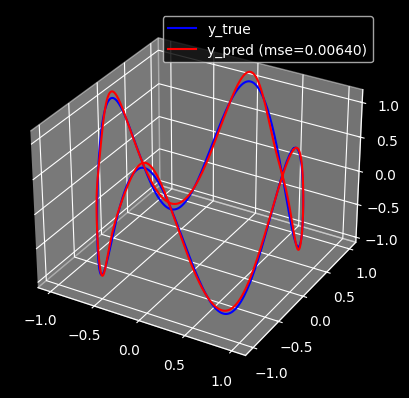

In [18]:
multi_head.eval()
with torch.no_grad():
  y_pred = multi_head(torch.tensor(x_circle, dtype=torch.float32, device='cuda'), x_trn, y_trn)
y_pred = y_pred.cpu().numpy().flatten()
mse = ((y_circle - y_pred)**2).mean()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot(x_circle[:,0], x_circle[:,1], y_circle, c='b', label='y_true')
ax.plot(x_circle[:,0], x_circle[:,1], y_pred, c='r', label=f'y_pred ({mse=:.5f})')
# markerline, stemlines, baseline = ax.stem(x_sample[:,0], x_sample[:,1], y_sample, label='y_sample')
# markerline.set_markerfacecolor('none')
plt.legend()
plt.show()